In [40]:
# === Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.layers import Bidirectional, Multiply
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional, Multiply, Lambda, Softmax,Activation

# === Load and Clean Data ===
url = "https://raw.githubusercontent.com/gyq1985/nlp/main/spam.csv"
df = pd.read_csv(url, encoding='latin-1')
df = df[['spamORham', 'Message']].rename(columns={'spamORham': 'label', 'Message': 'text'})

# === Encode Labels ===
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])
X = df['text']
Y = df['label'].values.reshape(-1, 1)

# === Train/Test Split ===
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

# === Tokenization (Improved) ===
# Increase vocabulary size to better capture rare spam tokens
max_words = 10000
max_len = 150
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure consistent input length
X_train_pad = sequence.pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = sequence.pad_sequences(X_test_seq, maxlen=max_len)

# === Class Weights ===
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(Y_train), y=Y_train.flatten())
class_weights = dict(enumerate(class_weights))

# === Build Model Function (improved) ===
def build_improved_model():
    inputs = Input(shape=(max_len,), name='input_layer')

    # Embedding Layer
    x = Embedding(input_dim=max_words, output_dim=128)(inputs)

    # Bidirectional LSTM
    x = Bidirectional(LSTM(64, return_sequences=True))(x)

    # Attention mechanism
    attention_weights = Dense(1, activation='tanh')(x)
    attention_weights = Softmax(axis=1)(attention_weights)
    context_vector = Multiply()([x, attention_weights])

    # Reduce over the sequence axis
    context_vector = Lambda(lambda t: tf.reduce_sum(t, axis=1))(context_vector)

    # Fully connected layers
    x = Dropout(0.3)(context_vector)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=output)
    return model


Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 32s 476ms/step - accuracy: 0.6291 - loss: 0.7008 - val_accuracy: 0.8430 - val_loss: 0.5275
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 28s 496ms/step - accuracy: 0.8929 - loss: 0.4541 - val_accuracy: 0.9148 - val_loss: 0.2476
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 39s 467ms/step - accuracy: 0.9652 - loss: 0.1010 - val_accuracy: 0.9709 - val_loss: 0.1124
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 40s 441ms/step - accuracy: 0.9919 - loss: 0.0437 - val_accuracy: 0.9686 - val_loss: 0.1616
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 41s 449ms/step - accuracy: 0.9947 - loss: 0.0235 - val_accuracy: 0.9652 - val_loss: 0.1740

Test Loss: 0.074  |  Test Accuracy: 0.981
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step

Classification Report:
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99       966
        spam       0.93      0.93      0.93       149

    accuracy                           0.98      1115
   macro avg       0.96      0

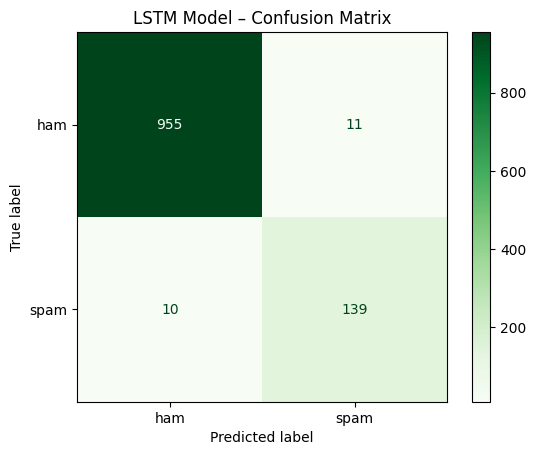

In [43]:
# === Compile and Train Model ===
model = build_improved_model()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(
    X_train_pad, Y_train,
    batch_size=64,
    epochs=10,
    validation_split=0.2,
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=1
)

# === Evaluate ===
loss, acc = model.evaluate(X_test_pad, Y_test, verbose=0)
print(f"\nTest Loss: {loss:.3f}  |  Test Accuracy: {acc:.3f}")

y_pred = (model.predict(X_test_pad) > 0.5).astype(int).flatten()
print("\nClassification Report:")
print(classification_report(Y_test, y_pred, target_names=le.classes_))
cm = confusion_matrix(Y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Greens', values_format='d')
plt.title("LSTM Model – Confusion Matrix")
plt.show()

In [44]:
# === Sample Test ===
samples = [
    # Spam examples
    "You’ve won a free gift card! Click here to claim now.",
    "URGENT! Your Netflix account has been locked. Reset now.",
    "Congratulations! You are our lucky survey winner.",
    "You've been selected to receive a new iPhone. Tap to confirm.",
    "Act now to claim your lottery prize. Offer expires soon.",
    "🔥 URGENT: Last chance to get 0% interest personal loan! Apply now at fastloan-now.com",
    "Hot singles in your area are waiting. Click to chat!",
    "⚠️ Your PayPal account is suspended. Log in now at verify-paypal-alert.com to restore access!",

    # Ham (legitimate) examples
    "Are we still meeting for lunch today?",
    "I'll call you later when I get off work.",
    "Can you please send me the report before 5 PM?",
    "Happy birthday! Hope you have a great day!",
    "Let's catch up sometime next week.",
    "Meeting is scheduled at 10 AM tomorrow. Don’t be late.",
    "I'm running late, will be there in 10 minutes."
]
sample_seq = tokenizer.texts_to_sequences(samples)
sample_pad = sequence.pad_sequences(sample_seq, maxlen=max_len)
preds = (model.predict(sample_pad) > 0.5).astype(int).flatten()
for msg, label in zip(samples, preds):
    print(f"Message: '{msg}' => Prediction: {'Spam' if label else 'Ham'}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
Message: 'You’ve won a free gift card! Click here to claim now.' => Prediction: Spam
Message: 'URGENT! Your Netflix account has been locked. Reset now.' => Prediction: Spam
Message: 'Congratulations! You are our lucky survey winner.' => Prediction: Spam
Message: 'You've been selected to receive a new iPhone. Tap to confirm.' => Prediction: Spam
Message: 'Act now to claim your lottery prize. Offer expires soon.' => Prediction: Spam
Message: '🔥 URGENT: Last chance to get 0% interest personal loan! Apply now at fastloan-now.com' => Prediction: Spam
Message: 'Hot singles in your area are waiting. Click to chat!' => Prediction: Spam
Message: '⚠️ Your PayPal account is suspended. Log in now at verify-paypal-alert.com to restore access!' => Prediction: Spam
Message: 'Are we still meeting for lunch today?' => Prediction: Ham
Message: 'I'll call you later when I get off work.' => Prediction: Ham
Message: 'Can you please send me the report before 5 PM?' => 